# Histograms with Examples
_Peering inside Histogram Bins with Spark and Bokeh_

<img src="https://github.com/pwais/oarphpy/blob/master/notebooks/hist-with-examples-diag.jpg?raw=true" alt="hist-with-examples" />

A histogram is one of the most effective tools for exploring a new dataset.  In one graph, a histogram displays key information about the data's mean, variance, outliers, and periodic features.  Histograms are so important than several libraries make histogramming extremely easy:
 * In [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html), the user can immediately plot a histogram from a Dataframe in a Jupyter notebook with a single function call.
 * [Tensorboard](https://github.com/tensorflow/tensorboard/blob/master/docs/r1/histograms.md) features a powerful temporal histogramming tool that can be critical for monitoring the weights of neural networks during training and debugging high-dimensional optimization problems.
 * [Bokeh](https://demo.bokeh.org/selection_histogram) provides a web-based histogram plotter with interactive tools and a nice Python API.

Histogram plots are often both surprising and boring: some bins have more items than expected, some bins have fewer, and a lot of bins are empty.  It's not unreasonable to immediately want to ask: can we peer inside a bin?  Which examples from my dataset are actually in there?  And, since this histogram only shows one dimension of the data, what might be some other dimensions or factors that are common among most of the things in that bin?

This tutorial will show you how OarphPy's `HistogramWithExamplesPlotter` helps you do exactly that!  What do you need?
 1. A DataFrame (Pandas or Spark) with at least one numeric or categorical column.
 2. A Python function for visualizing a row (or some portion of a row).  For example, a function to convert a row to a pretty string or HTML visualization.
 3. A Jupyter Notebook (like this one!) or a Python script to render the Bokeh HTML plot and display and/or save it to disk.

Why `HistogramWithExamplesPlotter` ?
 * We'll use Spark to compute the actual histogram.  Spark provides multi-cpu (and even multi-machine) processing to make histogramming scale linearly.
 * We'll also use Spark to render visualizations for the bucket items.  Spark's RDD API helps accomodate arbitrary user visualization functions and runs computation in parallel (even across many machines).
 * We use Bokeh's Histogram tool because it supports the simple interactivity we need (click on a bucket to view examples) and plots work in any modern browser with no extra dependencies.



## Notebook Setup

To run this notebook locally, try using the `oarphpy/full` dockerized environment:

```docker run -it --rm --net=host oarphpy/full:0.1.1 jupyter notebook --allow-root --ip="*"```

If you can't run the notebook locally, find an HTML-rendered copy [here](https://drive.google.com/file/d/1-uWxGQ7mrcY8aZMmBDc5AlV4kQAPLntR/view?usp=sharing).


**Google Colab**  You can also [run this notebook in Google Colab](https://colab.research.google.com/github/pwais/oarphpy/blob/v0.1.1/notebooks/Histogram_with_Examples.ipynb).  In the Colab environment, this notebook will install `oarphpy`, Spark, and Java.  Running the cell below will take care of that for you.  You might need to restart the runtime (Use the menu option: *Runtime* > *Restart runtime ...*) in order for Colab to recognize the new modules.

In [1]:
import os
import sys
if 'google.colab' in sys.modules:
    !pip install oarphpy[spark]==0.1.1
    !pip install pyspark==3.3.2
    !apt-get update && apt-get install -y openjdk-11-jdk
    os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

## A Motivating Example: Exploring Out-of-Distribution Robustness in MNIST

<img src="https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png" width="600" />
<center>An MNIST example input fed into a LeNet Network</center>


The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset is well-studied in Computer Vision and consists of thousands of small pictures of hand-written digits.  (New to MNIST? Suppose you're the Post Office and you want to train a Computer Vision model that can read the zipcode digits that people write on their mail.  MNIST has a sample of such handwritten digits).  Today, it's easy to train a convolutional neural network on MNIST and achieve over 98% accuracy.  We're going to do exactly that in the next notebook cell!  

But MNIST is a relatively small dataset versus all the digits people have ever written on paper.  How robust is a trained MNIST model to new data?  What if we don't have labels for that new data?  In this tutorial, we're going to use `HistogramWithExamplesPlotter` to examine the scores that an MNIST-trained model gives to "corrupted" data never seen at training time.

First, let's train a basic MNIST model using Pytorch:

In [2]:
!pip install -v tqdm torch

Using pip 23.0.1 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.4 MB/s eta 0:00:00
  changing mode of /usr/local/bin/tqdm to 755


In [3]:
# Basic MNIST ConvNet c/o Pytorch (with some small modifications noted)
# https://github.com/pytorch/examples/blob/40289773aa4916fad0d50967917b3ae8aa534fd6/mnist/main.py#L1

model_ckpt = '/opt/mnist_cnn.pt'

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

torch.manual_seed(1337)
if 'google.colab' in sys.modules:
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

# We need this many epochs to get a nice bimodal score distribution for the 7 class
N_EPOCHS = 15

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        # Use softmax instead for easier interpretation of logits
        # output = F.log_softmax(x, dim=1)
        output = F.softmax(x, dim=1)

        return output
    
def train(model, train_loader, optimizer, epoch):
    model.train()
    iter_train = tqdm(enumerate(train_loader), desc='train_batches', total=len(train_loader))
    for batch_idx, (data, target) in iter_train:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        
        # Push log into the loss instead of net output
        #loss = F.nll_loss(output, target)
        loss = F.nll_loss(torch.log(output), target)
        
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        iter_test = tqdm(test_loader, desc='test_batches', total=len(test_loader))
        for data, target in iter_test:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


train_kwargs = {'batch_size': 128}
test_kwargs = {'batch_size': 1024}
    
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('/opt/mnist-data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('/opt/mnist-data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(DEVICE)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

if os.path.exists(model_ckpt):
    print(f"Resuming from existing checkpoint {model_ckpt}")
    print(f"To re-train, delete the checkpoint: $ rm {model_ckpt}")
    model.load_state_dict(torch.load(model_ckpt))
else:
    print(f"Training and saving to {model_ckpt}")
    print("NOTE! If you'd like to skip training, you can download a copy of the model here:")
    print("https://drive.google.com/file/d/1rUey6jIW_duT20QNjnUL3i7LYI1u7IJW/view?usp=sharing")

    for epoch in tqdm(range(1, N_EPOCHS + 1), desc='epoch'):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader)
        scheduler.step()


    torch.save(model.state_dict(), model_ckpt)

x_test = torch.cat([xx[0] for xx in test_loader])

def model_predict(x):
    model.cpu().eval()
    with torch.no_grad():
        prob = model(x)
        pred = prob.argmax(dim=1, keepdim=True)
    return prob, pred



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /opt/mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to /opt/mnist-data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /opt/mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to /opt/mnist-data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /opt/mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to /opt/mnist-data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /opt/mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /opt/mnist-data/MNIST/raw

Training and saving to /opt/mnist_cnn.pt


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.198304


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9678, Accuracy: 9798/10000 (98%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.306051


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9788, Accuracy: 9844/10000 (98%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.142083


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9826, Accuracy: 9873/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.198513


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9850, Accuracy: 9890/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.184776


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9849, Accuracy: 9887/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.206751


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9855, Accuracy: 9881/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.204587


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9859, Accuracy: 9889/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.227512


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9865, Accuracy: 9889/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.190103


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9865, Accuracy: 9885/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 10 [44928/60000 (100%)]	Loss: 0.145944


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9863, Accuracy: 9889/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 11 [44928/60000 (100%)]	Loss: 0.171438


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9867, Accuracy: 9889/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 12 [44928/60000 (100%)]	Loss: 0.180739


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9868, Accuracy: 9891/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 13 [44928/60000 (100%)]	Loss: 0.156769


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9869, Accuracy: 9890/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 14 [44928/60000 (100%)]	Loss: 0.150828


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9868, Accuracy: 9891/10000 (99%)



train_batches:   0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 15 [44928/60000 (100%)]	Loss: 0.137323


test_batches:   0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: -0.9869, Accuracy: 9892/10000 (99%)



Now, let's run the trained model on the test set and pack the predictions into a Pandas DataFrame.  For each input, the network outputs a score for each class (the numbers 0 through 9).  We'll take a look at the raw network scores for the class "7," which is easy to confused for a "1". 

In [4]:
prob, pred = model_predict(x_test)

rows = []
for i, (x_i, score_i, pred_i) in enumerate(zip(x_test, prob, pred)):
    row = {}
    for classname, score in enumerate(score_i):
        row[f'score_{classname}'] = score.item()
    row['x_i'] = x_i.squeeze().tolist()
    rows.append(row)

import pandas as pd
prediction_df = pd.DataFrame(rows)
prediction_df

,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,x_i
0,1.666295e-12,9.708602e-11,1.020098e-08,1.268901e-09,4.895701e-12,1.794280e-12,4.720299e-15,1.000000e+00,9.185045e-12,4.956310e-09,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,6.385335e-08,1.281082e-06,9.999985e-01,4.398146e-10,7.451101e-12,7.687796e-13,1.296026e-07,7.235867e-11,1.650108e-09,9.231881e-14,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.790225e-08,9.999918e-01,2.045216e-07,6.124344e-09,3.181621e-06,9.231777e-08,5.492074e-07,4.090763e-06,1.358098e-07,4.678723e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,9.999950e-01,3.951097e-08,1.086515e-06,3.036769e-09,1.050577e-08,1.097534e-08,3.404809e-06,1.830841e-07,6.096547e-08,9.567390e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2.000482e-08,2.379246e-08,4.107488e-08,1.893190e-10,9.999777e-01,7.419485e-10,4.249667e-08,1.387315e-08,3.220784e-08,2.214572e-05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,9.127882e-12,8.512246e-08,9.999999e-01,5.384519e-09,2.463138e-14,4.580554e-15,2.152786e-13,1.736553e-08,8.733217e-10,3.547919e-15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9996,6.531591e-10,2.936270e-09,1.257551e-08,9.999963e-01,1.990298e-11,3.600434e-06,3.078520e-11,4.383115e-09,1.216664e-09,6.073076e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9997,1.076957e-14,7.316457e-10,1.751892e-13,6.589362e-14,1.000000e+00,3.043836e-12,1.105804e-11,2.092271e-09,4.008249e-09,1.101974e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9998,7.055724e-13,8.388026e-13,3.064934e-14,2.192952e-09,2.058131e-14,9.999999e-01,2.026460e-09,2.115985e-13,8.733659e-08,2.399424e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Now let's histogram the network's scores for the 7 class.  Note that since the network has high accuracy, the scores are rather cleanly bi-modal.  For this stage, we'll use the `pandas` built-in `hist()` feature, which gives us a histogram (though without examples or other visualization).

<Axes: >

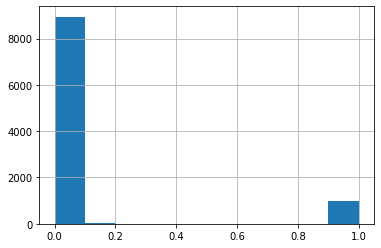

In [5]:
%matplotlib inline 
prediction_df['score_7'].hist()

## Simulating Out-of-Distribution Samples using MNIST-C: Corrupted MNIST

MNIST-C is a benchmark dataset derived from MNIST that has synthetic corruptions.  For example, in MNIST-C, digits are rotated, blurred, speckled, etc.  We will take the normal MNIST model we trained above, run inference on MNIST-C examples, and examine how well the corruption-unaware network generalizes.  This scenario simulates a common situation in production where one has a trained model, lots of unlabeled data, and little tooling for measuring or inspecting error in the wild.  We'll see how `HistogramWithExamplesPlotter` can be a useful tool for quick exploration. 

First, let's get the code for using MNIST-C:

In [6]:
!cd /opt && ((git clone https://github.com/pwais/oarphpy-mirror-mnist-c && \
              cd oarphpy-mirror-mnist-c && git checkout bba57e4ccc282f106907c5239958e72298451ea7) || echo "have mnist-c")
import sys
sys.path.append('/opt/oarphpy-mirror-mnist-c')

# These are hard requirements of the package we need from above
!pip3 install scikit-image==0.19.3
!pip3 install wand scipy
!ln -s /opt/oarphpy-mirror-mnist-c/pessimal_noise_matrix ./pessimal_noise_matrix || echo "symlink placed"
!apt-get install -y libmagickwand-dev


Cloning into 'oarphpy-mirror-mnist-c'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Receiving objects: 100% (22/22), 1.91 MiB | 5.01 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Note: switching to 'bba57e4ccc282f106907c5239958e72298451ea7'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at bba57e4 updated readme
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/

Get:6 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liblqr-1-0 amd64 0.4.2-2.1 [27.7 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libmagickcore-6.q16-6 amd64 8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1 [1789 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/main amd64 libdjvulibre-text all 3.5.28-2build2 [50.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy/main amd64 libdjvulibre21 amd64 3.5.28-2build2 [624 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libmagickwand-6.q16-6 amd64 8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1 [328 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/main amd64 libwmflite-0.2-7 amd64 0.2.12-5ubuntu1 [68.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libmagickcore-6.q16-6-extra amd64 8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1 [70.1 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy/main amd64 libbz2-dev amd64 1.0.8-5build1 [32.5 kB]
Get:14 http://archive.ubuntu.com/ubuntu jammy/main amd64 libjp

Get:83 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmagic-mgc amd64 1:5.41-3 [257 kB]
Get:84 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmagic1 amd64 1:5.41-3 [87.2 kB]
Get:85 http://archive.ubuntu.com/ubuntu jammy/main amd64 file amd64 1:5.41-3 [21.5 kB]
Get:86 http://archive.ubuntu.com/ubuntu jammy/main amd64 bzip2-doc all 1.0.8-5build1 [500 kB]
Get:87 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-mono all 20201225-1build1 [397 kB]
Get:88 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-urw-base35 all 20200910-1 [6367 kB]
Get:89 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgs9-common all 9.55.0~dfsg1-0ubuntu5.1 [751 kB]
Get:90 http://archive.ubuntu.com/ubuntu jammy/main amd64 libidn12 amd64 1.38-4build1 [60.6 kB]
Get:91 http://archive.ubuntu.com/ubuntu jammy/main amd64 libijs-0.35 amd64 0.35-15build2 [16.5 kB]
Get:92 http://archive.ubuntu.com/ubuntu jammy/main amd64 libjbig2dec0 amd64 0.19-3build2 [64.7 kB]
Get:93 http://archive.

Selecting previously unselected package libilmbase-dev:amd64.
Preparing to unpack .../031-libilmbase-dev_2.5.7-2_amd64.deb ...
Unpacking libilmbase-dev:amd64 (2.5.7-2) ...
Selecting previously unselected package libopenexr-dev.
Preparing to unpack .../032-libopenexr-dev_2.5.7-1_amd64.deb ...
Unpacking libopenexr-dev (2.5.7-1) ...
Selecting previously unselected package gir1.2-freedesktop:amd64.
Preparing to unpack .../033-gir1.2-freedesktop_1.72.0-1_amd64.deb ...
Unpacking gir1.2-freedesktop:amd64 (1.72.0-1) ...
Selecting previously unselected package gir1.2-gdkpixbuf-2.0:amd64.
Preparing to unpack .../034-gir1.2-gdkpixbuf-2.0_2.42.8+dfsg-1ubuntu0.2_amd64.deb ...
Unpacking gir1.2-gdkpixbuf-2.0:amd64 (2.42.8+dfsg-1ubuntu0.2) ...
Selecting previously unselected package gir1.2-rsvg-2.0:amd64.
Preparing to unpack .../035-gir1.2-rsvg-2.0_2.52.5+dfsg-3_amd64.deb ...
Unpacking gir1.2-rsvg-2.0:amd64 (2.52.5+dfsg-3) ...
Selecting previously unselected package liblzo2-2:amd64.
Preparing to unpac

Selecting previously unselected package libicu-dev:amd64.
Preparing to unpack .../075-libicu-dev_70.1-2_amd64.deb ...
Unpacking libicu-dev:amd64 (70.1-2) ...
Selecting previously unselected package libxml2-dev:amd64.
Preparing to unpack .../076-libxml2-dev_2.9.13+dfsg-1ubuntu0.2_amd64.deb ...
Unpacking libxml2-dev:amd64 (2.9.13+dfsg-1ubuntu0.2) ...
Selecting previously unselected package libmagickcore-6.q16-dev:amd64.
Preparing to unpack .../077-libmagickcore-6.q16-dev_8%3a6.9.11.60+dfsg-1.3ubuntu0.22.04.1_amd64.deb ...
Unpacking libmagickcore-6.q16-dev:amd64 (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1) ...
Selecting previously unselected package libmagickwand-6-headers.
Preparing to unpack .../078-libmagickwand-6-headers_8%3a6.9.11.60+dfsg-1.3ubuntu0.22.04.1_all.deb ...
Unpacking libmagickwand-6-headers (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1) ...
Selecting previously unselected package libmagickwand-6.q16-dev:amd64.
Preparing to unpack .../079-libmagickwand-6.q16-dev_8%3a6.9.11.60+dfsg-1.3ubun

Setting up libtiffxx5:amd64 (4.3.0-6ubuntu0.3) ...
Setting up libbz2-dev:amd64 (1.0.8-5build1) ...
Setting up libgs9-common (9.55.0~dfsg1-0ubuntu5.1) ...
Setting up libcairo-script-interpreter2:amd64 (1.16.0-5ubuntu2) ...
Setting up libblkid-dev:amd64 (2.37.2-4ubuntu3) ...
Setting up libmagickcore-6-arch-config:amd64 (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1) ...
Setting up libjxr-tools (1.2~git20170615.f752187-5) ...
Setting up libgs9:amd64 (9.55.0~dfsg1-0ubuntu5.1) ...
Setting up libpcre2-dev:amd64 (10.39-3ubuntu0.1) ...
Setting up libtool (2.4.6-15build2) ...
Setting up libselinux1-dev:amd64 (3.3-1build2) ...
Setting up libpcre3-dev:amd64 (2:8.39-13ubuntu0.22.04.1) ...
Setting up libmagickwand-6-headers (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1) ...
Setting up libdjvulibre21:amd64 (3.5.28-2build2) ...
Setting up libjpeg-dev:amd64 (8c-2ubuntu10) ...
Setting up liblqr-1-0-dev:amd64 (0.4.2-2.1) ...
Setting up m4 (1.4.18-5ubuntu2) ...
Setting up ghostscript (9.55.0~dfsg1-0ubuntu5.1) ...
Setting u

Let's take a look at a single corrupted example:

In [7]:
import corruptions

# See more corruptions here: 
# https://github.com/google-research/mnist-c/blob/bba57e4ccc282f106907c5239958e72298451ea7/corruptions.py#L57 

x_to_corrupt = x_test[100].squeeze() * 255
# x_corrupted = corruptions.speckle_noise(x_to_corrupt)
# x_corrupted = corruptions.glass_blur(x_to_corrupt, severity=4)
x_corrupted = corruptions.rotate(x_to_corrupt, severity=4)

x_corrupted.shape

(28, 28)

In [8]:
sys.path.append('/opt/oarphpy')
from oarphpy.plotting import img_to_img_tag

img_html = img_to_img_tag(x_to_corrupt)
img_html_c = img_to_img_tag(x_corrupted)

def show_html(html):
    from IPython.core.display import display, HTML
    display(HTML(html))
show_html('<b>Original:</b>' + img_html)
show_html('<b>Corrupted:</b>' + img_html_c)

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 233.87545776367188]. Convert image to uint8 prior to saving to suppress this warning.


Now, let's generated corrupted versions for the entire MNIST test set, and run inference of our earlier model on these corrupted examples:

In [9]:
import numpy as np
x_test_c = np.zeros_like(x_test)
for i in tqdm(range(len(x_test_c)), total=len(x_test_c)):
    # xform = corruptions.glass_blur
    xform = corruptions.rotate
    x_test_c[i][0] = (1. / 255) * xform(x_test[i].squeeze() * 255, severity=4)


  0%|          | 0/10000 [00:00<?, ?it/s]

Let's make sure that worked and also declare a utility function for visualizing digits:

In [10]:
NUM_TO_SHOW = 10

def unit_digit_to_img_tag(x):
    img_char = (255 * x).astype('uint8')
    return img_to_img_tag(img_char)

for r in x_test_c[:NUM_TO_SHOW, ...]:
    x_i = r.squeeze()
    show_html(unit_digit_to_img_tag(x_i))

Now let's run inference on the corrupted data!

In [11]:
prob_c, pred_c = model_predict(torch.from_numpy(x_test_c))

In [12]:
# Aggregate inference results into a dataframe
rows = []
for i, (x_i, score_i, pred_i) in enumerate(zip(x_test_c, prob_c, pred_c)):
    row = {}
    for classname, score in enumerate(score_i):
        row[f'score_{classname}'] = score.item()
    row['x_i'] = x_i.squeeze().tolist()
    rows.append(row)

import pandas as pd
prediction_c_df = pd.DataFrame(rows)
prediction_c_df

,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,x_i
0,0.023189,3.499873e-02,7.924204e-02,2.462936e-03,7.328708e-01,2.511773e-03,0.000694,5.893948e-02,0.004421,0.060670,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.136875,1.656399e-01,1.804453e-02,8.661019e-04,2.014344e-02,1.060956e-02,0.185269,3.871693e-02,0.423418,0.000418,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.000057,2.777056e-02,4.605581e-01,4.355606e-02,1.046089e-03,8.797347e-03,0.001094,1.946782e-02,0.437414,0.000240,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0.999870,4.705473e-07,1.019485e-05,6.493735e-08,1.318491e-06,8.314926e-06,0.000059,3.484946e-05,0.000013,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0.002216,1.544213e-05,2.452351e-03,3.282306e-04,8.513890e-03,5.292688e-01,0.022211,1.086944e-03,0.264774,0.169133,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000160,2.077016e-06,9.966429e-01,1.492914e-04,7.414887e-07,9.567250e-07,0.000006,4.912279e-05,0.002986,0.000003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9996,0.002529,5.961329e-05,8.055447e-04,9.899822e-01,2.514886e-06,6.705057e-04,0.000006,3.017469e-04,0.000128,0.005515,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9997,0.001643,2.136260e-04,8.218874e-01,5.305554e-03,7.188972e-04,1.871666e-02,0.063834,5.108909e-04,0.086146,0.001024,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9998,0.000001,3.017144e-07,2.192112e-08,1.729715e-04,4.796895e-05,3.358821e-01,0.663164,5.775211e-09,0.000685,0.000047,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Ok, so how did the network score the `7` class in the corrupted data?

<Axes: >

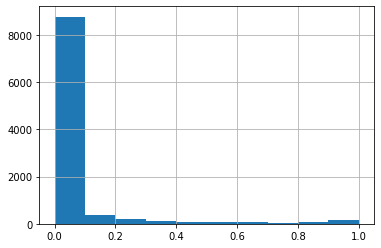

In [13]:
prediction_c_df['score_7'].hist()

Huh, that score distribution is still bi-modal, but is *much more uniform* than the plot we saw earlier.  Clearly the model is making mistakes due to the corruptions.  But what sorts of mistakes?  If we needed to select some of these examples to label, which would we choose?  Let's use `HistogramWithExamplesPlotter` to "peer inside" the histogram buckets of the plot above.

In [14]:
from oarphpy.spark import NBSpark
spark = NBSpark.getOrCreate()


2023-03-06 08:13:58,093	oarph 195 : Using source root /usr/lib/python3/dist-packages/IPython/core 
2023-03-06 08:13:58,094	oarph 195 : Using source root /usr/lib/python3/dist-packages/IPython 
2023-03-06 08:13:58,127	oarph 195 : Generating egg to /tmp/tmp6gziyi2u_oarphpy_eggbuild ...
2023-03-06 08:13:58,366	oarph 195 : ... done.  Egg at /tmp/tmp6gziyi2u_oarphpy_eggbuild/core-0.0.0-py3.10.egg
23/03/06 08:14:00 WARN Utils: Your hostname, mrskylake resolves to a loopback address: 127.0.1.1; using 192.168.0.202 instead (on interface enp59s0)
23/03/06 08:14:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/03/06 08:14:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
INFO:SparkMonitorKernel:Client Connected ('127.0.0.1', 49758)


In [15]:
from bokeh.plotting import figure
from bokeh.io import output_notebook
from bokeh.io import show as bokeh_show
output_notebook()


Loading BokehJS ...

In [16]:
prediction_c_sdf = spark.createDataFrame(prediction_c_df)

# To see the text representation of a Spark Dataframe try:
# prediction_c_sdf.show()

In [ ]:
from oarphpy import plotting as pl
class MyPlotter(pl.HistogramWithExamplesPlotter):
    NUM_BINS = 20
    def display_bucket(self, sub_pivot, bucket_id, irows):
        MAX_TO_VIZ = 50
        
        from oarphpy.plotting import img_to_img_tag
        htmls = []
        for row in irows:
            htmls.append(unit_digit_to_img_tag(np.array(row['x_i'])))
            
            if len(htmls) > MAX_TO_VIZ:
                break
        
        # Make a nice table
        N_COLS = 25
        from oarphpy.util import ichunked
        trs = [
            "<tr>%s</tr>" % ''.join("<td>%s</td>" % ihtml for ihtml in row)
            for row in ichunked(htmls, n=N_COLS) 
        ]
        table_html = "<table>%s</table>" % ''.join(trs)
        
        return bucket_id, table_html

plotter = MyPlotter()
fig = plotter.run(prediction_c_sdf, 'score_7')
bokeh_show(fig)

In [ ]:
fig = plotter.run(spark.createDataFrame(prediction_c_df), 'score_1')
bokeh_show(fig)

The two figures above examine the model's inferences on the _corrupted_ dataset.  Let's use `HistogramWithExamplesPlotter` to visualize the inference results on the original MNIST dataset to compare:

In [ ]:
fig = plotter.run(spark.createDataFrame(prediction_df), 'score_7')
bokeh_show(fig)

For more examples of `HistogramWithExamplesPlotter`, see these rendered HTML pages: https://drive.google.com/drive/folders/1dOmkPvdFiGBMaYEddx1KK5vmCeYl2CyV?usp=sharing 